In [116]:
import numpy as np
from scipy.misc import factorial
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Note that this is actually not a good way to sample from a Poisson distribution.

Just meant to be an example of a simple Metropolis-Hastings sampler.

In [180]:
def poisson_E(n, lam):
    "Poisson energy (negative log) of the probability."
    return -n * np.log(lam) + lam + np.log(factorial(n))

def poisson_P(n, lam):
    "Poisson probability."
    return np.exp(-poisson_E(n, lam))

In [181]:
def sample_poisson(lam, size, burn_in=None, between=None):
    """Sample from a Poisson distribution using a Metropolis-Hastings scheme.
    
    Parameters
    ----------
    lam : float
        Poisson mean (and var) parameter.
    size : int or tuple/list of ints
        Size of samples array.
    burn_in : int
        Number of steps to burn in before taking samples.
    between : int
        Number of steps to take between samples."""
    curr = int(np.floor(lam))
    if burn_in is None:
        burn_in = max(1, curr) * 10
    if between is None:
        between = max(1, curr)
    total = np.prod(size)
    samples = np.zeros(total, dtype=int)

    def one_step(curr, lam):
        """Takes one M-H step."""
        # Make M-H proposal
        if curr == 0:
            prop = 1
            prop_ratio = .5
        else:
            prop = curr + (2 * np.random.binomial(1, .5)) - 1
            if prop == 0:
                prop_ratio = 2.
            else:
                prop_ratio = 1.

        # Accept/reject new sample
        p_ratio = np.exp(-(poisson_E(prop, lam) - poisson_E(curr, lam)))
        a = prop_ratio * p_ratio
        if a > 1:
            curr = prop
        else:
            if np.random.binomial(1, a):
                curr = prop
        return curr

    for ii in range(burn_in):
        curr = one_step(curr, lam)

    for ii in range(total):
        samples[ii] = curr
        for jj in range(between):
            curr = one_step(curr, lam)

    return samples.reshape(size)

In [182]:
lam = 3.5
diffs = []
ns = np.logspace(2, 6, 20, dtype=int)
for n in ns:
    x = sample_poisson(lam, n)
    m = x.max()
    bins = np.linspace(0, m, m+1)
    dp, b = np.histogram(x, bins, density=True)
    d = poisson_P(bins[:-1], lam)
    diffs.append(abs(d - dp).sum())

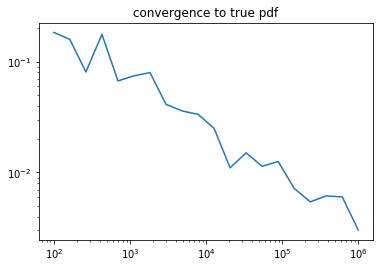

In [188]:
plt.plot(ns, diffs)
plt.yscale('log')
plt.xscale('log')
plt.title('convergence to true pdf')

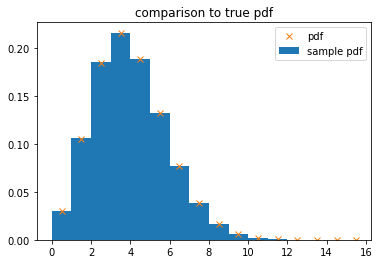

In [187]:
plt.hist(x, bins, normed=True, label='sample pdf')
plt.plot(bins+.5, poisson_P(bins, lam), 'x', label='pdf')
plt.legend()
plt.title('comparison to true pdf')

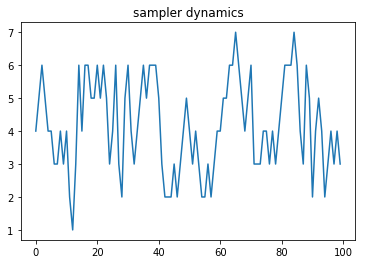

In [186]:
plt.plot(x[:100])
plt.title('sampler dynamics')